In [1]:
from platform import python_version
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

print(f'python {python_version()}')
print(f'pandas {pd.__version__}')
print(f'numpy {np.__version__}')
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy import integrate
import seaborn as sns
print(f'lgb {lgb.__version__}')
import operator
import datetime

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import ks_2samp
import random
import copy

from scipy.stats import norm, kurtosis
from sklearn.metrics import make_scorer
from utils import *

python 3.7.7
pandas 1.0.4
numpy 1.18.1
lgb 2.3.1


In [2]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import layers, models, optimizers
from keras.layers import Dense, Activation, BatchNormalization, AlphaDropout, Dropout, Add, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.models import Sequential, Model, Input, load_model

from keras.wrappers.scikit_learn import KerasRegressor


Using TensorFlow backend.


In [3]:
def mish(x):
    return x*K.tanh(K.softplus(x))

def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    
    lrate = max(1e-5, lrate)
    return lrate

es = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)
lrs = keras.callbacks.LearningRateScheduler(step_decay)

In [4]:
train_features = pd.read_csv('./data/train_features.csv')
train_target = pd.read_csv('./data/train_target.csv')
test_features = pd.read_csv('./data/test_features.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')


In [ ]:
fs = 5
# sampling frequency 
fmax = 32
# sampling period
dt = 1/fs
# length of signal
N  = 128

df = fmax/N
f = np.arange(0,N)*df

train_ids = train_features.drop_duplicates(['id'])['id'].values

signals = []
ss = pd.DataFrame()
sss = [[] for _ in range(4)]

for i in tqdm(train_ids):
    xf1 = np.fft.fft(train_features[train_features.id==i]['S1'].values)*dt
    xf2 = np.fft.fft(train_features[train_features.id==i]['S2'].values)*dt
    xf3 = np.fft.fft(train_features[train_features.id==i]['S3'].values)*dt
    xf4 = np.fft.fft(train_features[train_features.id==i]['S4'].values)*dt
    
    signals.append(np.concatenate([np.abs(xf1[0:int(N/2+1)]), np.abs(xf2[0:int(N/2+1)]), np.abs(xf3[0:int(N/2+1)]), np.abs(xf4[0:int(N/2+1)])]))
    ss['s1'] = np.abs(xf1[0:int(N/2+1)])
    ss['s2'] = np.abs(xf2[0:int(N/2+1)])
    ss['s3'] = np.abs(xf3[0:int(N/2+1)])
    ss['s4'] = np.abs(xf4[0:int(N/2+1)])
    
signals = np.array(signals)

In [ ]:
signals[0]

In [ ]:
signals.reshape((2800, 65, 4, 1))[0]

In [12]:
# stats_train = get_stats_features(train_features)
# rolling_train= get_rolling_features(train_features)
# fre_train= get_frequency_features(train_features)
mfcc_train = get_mfcc_features(train_features)
# time_train = get_every_s2(train_features)
time_train = get_arrival_time_features(train_features)

# stats_test = get_stats_features(test_features)
# rolling_test= get_rolling_features(test_features)
# fre_test= get_frequency_features(test_features)
mfcc_test = get_mfcc_features(test_features)
# time_test = get_every_s2(test_features)
time_test = get_arrival_time_features(test_features)

100%|██████████| 700/700 [00:00<00:00, 1160.61it/s]


In [13]:
newc = [c for c in time_train.columns if len(c)==6]
oldc = [c for c in time_train.columns if c not in newc]

# time_test[newc] /= time_train[newc].max().abs()
# time_train[newc] /= time_train[newc].max().abs()

time_test[oldc] /= time_train[oldc].max().abs()
time_train[oldc] /= time_train[oldc].max().abs()


In [14]:
# mfcc
a = np.zeros_like(mfcc_train.values)
for i in mfcc_train.index:
    temp = mfcc_train.loc[i]
    a[i] = temp /np.max(abs(temp))
mfcc_train.iloc[:,:] = a

b = np.zeros_like(mfcc_test.values)
for i in mfcc_test.index:
    temp = mfcc_test.loc[i]
    b[i-mfcc_test.index[0]] = temp / np.max(np.abs(temp))
mfcc_test.iloc[:,:] = b

ctd = []
for c in mfcc_train.columns:
    if mfcc_train[c].std()==0 or mfcc_test[c].std()==0:
        print(c)
        ctd.append(c)
mfcc_train = mfcc_train.drop(ctd, axis=1)
mfcc_test = mfcc_test.drop(ctd, axis=1)
mfcc_test.head()

summfcc2


,summfcc0,summfcc1,summfcc3,summfcc4,summfcc5,summfcc6,summfcc7,summfcc8,summfcc9,summfcc10,...,summfcc22,summfcc23,summfcc24,summfcc25,summfcc26,summfcc27,summfcc28,summfcc29,summfcc30,summfcc31
0,0.412495,-0.185278,-0.105264,0.054041,0.047784,-0.158039,-0.069546,0.165552,-0.093065,0.037431,...,0.003289,0.004101,-0.013455,-0.009239,0.011622,0.007005,-0.030716,0.040807,0.026494,-0.026201
1,0.428403,-0.193016,0.112847,0.163353,0.128408,-0.134335,-0.012366,0.132453,-0.272094,0.048642,...,-0.000653,0.001649,-0.014744,0.012564,0.015587,-0.032641,0.062836,0.018460,-0.046446,0.051808
2,0.420741,-0.301935,0.259475,0.189514,-0.116479,-0.040612,0.036970,0.016508,-0.174352,0.167865,...,0.009216,0.000094,0.001332,-0.026531,0.024633,0.027110,0.003344,0.027999,-0.056827,0.000971
3,0.389785,-0.387673,0.194345,0.058999,-0.098376,-0.048043,0.065378,-0.062923,-0.126855,0.087885,...,0.007122,0.001814,-0.000087,-0.019212,0.035761,-0.013621,-0.009270,0.056205,-0.035715,0.032174
4,0.441815,-0.112607,-0.106618,0.080004,0.066730,-0.194693,-0.149091,0.124902,-0.142856,-0.154909,...,0.011096,0.002494,-0.008747,-0.002032,0.030447,0.037405,-0.014775,-0.002822,0.018688,-0.080422


In [15]:
train_X_feat = pd.concat([time_train, mfcc_train], axis=1)

test_X_feat = pd.concat([time_test.reset_index().drop('index', axis=1),
                    mfcc_test.reset_index().drop('index', axis=1),
                   ], axis=1)

train_X_feat = train_X_feat.T.drop_duplicates().T
# ctd = [c for c in test_X.columns if c not in train_X.columns]
test_X_feat = test_X_feat[train_X_feat.columns]

In [16]:
train_X = train_features.iloc[:,2:].values.reshape((2800,375,4,1))
test_X = test_features.iloc[:,2:].values.reshape((700,375,4,1))
train_y = train_target.iloc[:,1:].values

# tr_X, te_X, tr_y, te_y = train_test_split(train_X, train_y, test_size=0.3, random_state=42)
tr_X, te_X, tr_feat_X, te_feat_X, tr_y, te_y = train_test_split(train_X, train_X_feat, train_y, test_size=0.3, random_state=42)

In [6]:
weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))


def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [7]:
K.clear_session()
def set_model(train_target):  # 0:x,y, 1:m, 2:v
    
    activation = mish
    padding = 'valid'
    model = Sequential()
    kernel_initializer = 'he_normal'
    nf = 16
    fs = (2,1)

    model.add(Conv2D(nf,fs, padding=padding, activation=activation,input_shape=(375,4,1), kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2, 1)))
 
    model.add(Flatten())
    
    model.add(Dense(128, activation =activation, kernel_initializer=kernel_initializer))
    model.add(Dense(64, activation =activation, kernel_initializer=kernel_initializer))
    model.add(Dense(32, activation =activation, kernel_initializer=kernel_initializer))
    model.add(Dense(16, activation =activation, kernel_initializer=kernel_initializer))
    
    model.add(Dense(4, kernel_initializer=kernel_initializer))

    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
        
    model.summary()

    return model

In [8]:
set_model(0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 374, 4, 16)        48        
_________________________________________________________________
batch_normalization_1 (Batch (None, 374, 4, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 187, 4, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 186, 4, 32)        1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 186, 4, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 93, 4, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 4, 64)        

In [25]:
K.clear_session()
def build_model(train_target):
    activation = tf.nn.swish
    padding = 'valid'
    model = Sequential()
    kernel_initializer = 'he_normal'
    nf = 16
    fs1 = (2, 1)
    
    inputs = Input(shape=(375,4,1))
    
    sub_inputs = Input(shape = (59, ))
    s = Dense(64, activation=activation, kernel_initializer=kernel_initializer)(sub_inputs)
    
    x = Conv2D(nf,fs1, padding=padding, activation=activation, kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = MaxPooling2D((2, 1))(x)
    
    for i in range(5):
        x = Conv2D(nf*(2**(i+1)), fs1,  activation=activation, kernel_initializer=kernel_initializer, padding=padding)(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = MaxPooling2D((2, 1))(x)
        
    x = Flatten()(x)
    
    x = Dense(128, activation=activation)(x)
    x = Concatenate()([x, s])
    x = BatchNormalization(momentum=0.9)(x)
    x = Dense(64, activation=activation)(x)
    x = Dense(32, activation=activation)(x)
    x = Dense(16, activation=activation)(x)
    
    outputs = Dense(4)(x)
    
    model = Model([inputs, sub_inputs], outputs)
    
    optimizer = keras.optimizers.Adam()

    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
        
    model.summary()
    
    return model
    
    

In [ ]:
build_model(1)

In [27]:
def train(model,X,Y):
    MODEL_SAVE_FOLDER_PATH = './model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

#     model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
#     best_save = keras.callbacks.ModelCheckpoint('best_m.hdf5', save_best_only=True, monitor='val_loss', mode='min')


    history = model.fit(X, Y,
                  epochs=500,
#                   batch_size=256,
                  shuffle=True,
                  validation_split=0.2,
                  verbose = 2,
                  callbacks=[es])

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    

    return model

In [28]:
def load_best_model(train_target):

    if train_target == 0:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E1': my_loss, 'mish': mish, })
    else:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E2': my_loss, 'mish': mish,})

    score = model.evaluate(te_X, te_y, verbose=0)
    print('loss:', score)

    pred = model.predict(te_X)

    i=0

    print('정답(original):', te_y[i])
    print('예측값(original):', pred[i])

    print(E1(pred, te_y))
    print(E2(pred, te_y))
#     print(E2M(pred, te_y))
#     print(E2V(pred, te_y))    
    
#     if train_target ==0:
#         plot_error(4,pred,te_y)
#     elif train_target ==1:
#         plot_error(2,pred,te_y)
#     elif train_target ==2:
#         plot_error(3,pred,te_y)    
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 375, 4, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 374, 4, 16)   48          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 374, 4, 16)   64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 187, 4, 16)   0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

Epoch 39/500
 - 1s - loss: 7.3429e-04 - val_loss: 0.0061
Epoch 40/500
 - 1s - loss: 7.1372e-04 - val_loss: 0.0054
Epoch 41/500
 - 1s - loss: 6.8622e-04 - val_loss: 0.0021
Epoch 42/500
 - 1s - loss: 9.1179e-04 - val_loss: 0.0013
Epoch 43/500
 - 1s - loss: 8.7122e-04 - val_loss: 0.0016
Epoch 44/500
 - 1s - loss: 0.0011 - val_loss: 0.0120
Epoch 45/500
 - 1s - loss: 0.0010 - val_loss: 0.0063
Epoch 46/500
 - 1s - loss: 9.3542e-04 - val_loss: 0.0048
Epoch 47/500
 - 1s - loss: 9.6841e-04 - val_loss: 0.0030
Epoch 48/500
 - 1s - loss: 7.1333e-04 - val_loss: 0.0042
Epoch 49/500
 - 1s - loss: 8.4043e-04 - val_loss: 0.0018
Epoch 50/500
 - 1s - loss: 9.4928e-04 - val_loss: 0.0031
Epoch 51/500
 - 1s - loss: 6.9937e-04 - val_loss: 0.0012
Epoch 52/500
 - 1s - loss: 7.4012e-04 - val_loss: 0.0058
Epoch 53/500
 - 1s - loss: 0.0011 - val_loss: 0.0016
Epoch 54/500
 - 1s - loss: 6.0149e-04 - val_loss: 0.0064
Epoch 55/500
 - 1s - loss: 8.1195e-04 - val_loss: 0.0102
Epoch 56/500
 - 1s - loss: 6.5236e-04 - val

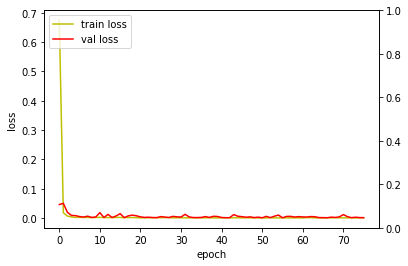

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 375, 4, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 374, 4, 16)   48          input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 374, 4, 16)   64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 187, 4, 16)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

Epoch 38/500
 - 1s - loss: 5.7218e-04 - val_loss: 7.5502e-04
Epoch 39/500
 - 1s - loss: 0.0011 - val_loss: 4.3823e-04
Epoch 40/500
 - 1s - loss: 7.2549e-04 - val_loss: 7.6754e-04
Epoch 41/500
 - 1s - loss: 0.0015 - val_loss: 6.2463e-04
Epoch 42/500
 - 1s - loss: 0.0015 - val_loss: 0.0013
Epoch 43/500
 - 1s - loss: 6.3221e-04 - val_loss: 5.4205e-04
Epoch 44/500
 - 1s - loss: 0.0011 - val_loss: 7.2731e-04
Epoch 45/500
 - 1s - loss: 7.5054e-04 - val_loss: 4.7384e-04
Epoch 46/500
 - 1s - loss: 5.3006e-04 - val_loss: 5.0107e-04
Epoch 47/500
 - 1s - loss: 5.2916e-04 - val_loss: 4.3316e-04
Epoch 48/500
 - 1s - loss: 4.4085e-04 - val_loss: 0.0013
Epoch 49/500
 - 1s - loss: 7.2591e-04 - val_loss: 7.8292e-04
Epoch 50/500
 - 1s - loss: 5.6562e-04 - val_loss: 0.0012
Epoch 51/500
 - 1s - loss: 6.0189e-04 - val_loss: 4.2273e-04
Epoch 52/500
 - 1s - loss: 6.4002e-04 - val_loss: 4.9218e-04
Epoch 53/500
 - 1s - loss: 0.0010 - val_loss: 0.0016
Epoch 54/500
 - 1s - loss: 5.8287e-04 - val_loss: 4.3271e-04

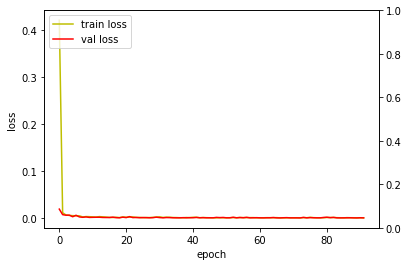

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 375, 4, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 374, 4, 16)   48          input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 374, 4, 16)   64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 187, 4, 16)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

 - 1s - loss: 0.0015 - val_loss: 8.0568e-04
Epoch 38/500
 - 1s - loss: 0.0010 - val_loss: 4.7961e-04
Epoch 39/500
 - 1s - loss: 0.0015 - val_loss: 7.0091e-04
Epoch 40/500
 - 1s - loss: 0.0015 - val_loss: 7.7874e-04
Epoch 41/500
 - 1s - loss: 5.5965e-04 - val_loss: 4.1648e-04
Epoch 42/500
 - 1s - loss: 7.4714e-04 - val_loss: 5.9544e-04
Epoch 43/500
 - 1s - loss: 4.3854e-04 - val_loss: 0.0012
Epoch 44/500
 - 1s - loss: 6.9828e-04 - val_loss: 6.9840e-04
Epoch 45/500
 - 1s - loss: 6.7763e-04 - val_loss: 6.6799e-04
Epoch 46/500
 - 1s - loss: 5.2389e-04 - val_loss: 5.3478e-04
Epoch 47/500
 - 1s - loss: 4.7004e-04 - val_loss: 5.6968e-04
Epoch 48/500
 - 1s - loss: 3.9775e-04 - val_loss: 4.8891e-04
Epoch 49/500
 - 1s - loss: 7.0287e-04 - val_loss: 8.0939e-04
Epoch 50/500
 - 1s - loss: 4.9962e-04 - val_loss: 8.3037e-04
Epoch 51/500
 - 1s - loss: 7.3488e-04 - val_loss: 3.8624e-04
Epoch 52/500
 - 1s - loss: 9.9816e-04 - val_loss: 7.9134e-04
Epoch 53/500
 - 1s - loss: 8.6109e-04 - val_loss: 4.9399e

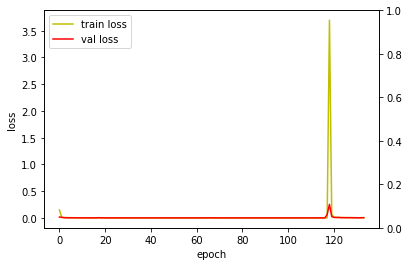

0.44671040312704746


In [29]:
MODEL_SAVE_FOLDER_PATH = './model/'
sub = pd.read_csv('./data/sample_submission.csv')
te_ys = pd.DataFrame(np.zeros_like(te_y), columns=['X', 'Y', 'M', 'V'])

models = [None for _ in range(3)]
for train_target in range(3):
#     model = set_model(train_target)
    model = build_model(train_target)
    models[train_target] = train(model,[tr_X, tr_feat_X], tr_y)    
#     best_model = load_best_model(train_target)

    pred_data_test = models[train_target].predict([test_X, test_X_feat])
    val_pred =  models[train_target].predict([te_X, te_feat_X])

    
    if train_target == 0: # x,y 학습
        sub.iloc[:,1] = pred_data_test[:,0]
        sub.iloc[:,2] = pred_data_test[:,1]
        te_ys.iloc[:,0] = val_pred[:,0]
        te_ys.iloc[:,1] = val_pred[:,1]

    elif train_target == 1: # m 학습
        sub.iloc[:,3] = np.clip(pred_data_test[:,2], 0, 1)
        te_ys.iloc[:,2] = val_pred[:,2]

    elif train_target == 2: # v 학습
        sub.iloc[:,4] = np.clip(pred_data_test[:,3], 0, 1)
        te_ys.iloc[:,3] = val_pred[:,3]
        
val_score = kaeri_metric(te_y, te_ys)
print(val_score)

In [ ]:
sub

In [ ]:
sub

In [ ]:
model_path = f'./model/{round(val_score, 5)}'
os.mkdir(model_path)
for i in range(3):
    models[i].save(model_path+f'/model_{i}')

In [ ]:
val_score

In [ ]:
sub.to_csv('./sub/cnn_test2.csv', index=False)